In [53]:
# ==========================================
# 1. USER INPUTS (Adjust these variables)
# ==========================================
target_z = -1.0        # Desired Focus Depth (mm) e.g., -1.0, -2.0
feedrate = 3000        # Speed (mm/min)
pwm_freq = 4000        # PWM Frequency (Hz)
overlap_target = 0.50  # Desired Overlap (20% is standard for smooth floors)

# Machine Baseline (TTS-55 Pro Data based on our conversation)
base_spot_0mm = 0.08   # Spot size at perfect focus
base_spot_2mm = 0.18   # Spot size at -2mm defocus
max_scale = 4000      # S-Value Scale (1000 or 255)

# Known "Good" calibration point (from our findings at -2mm)
ref_z = -2.0
ref_power_min = 20
ref_power_max = 90

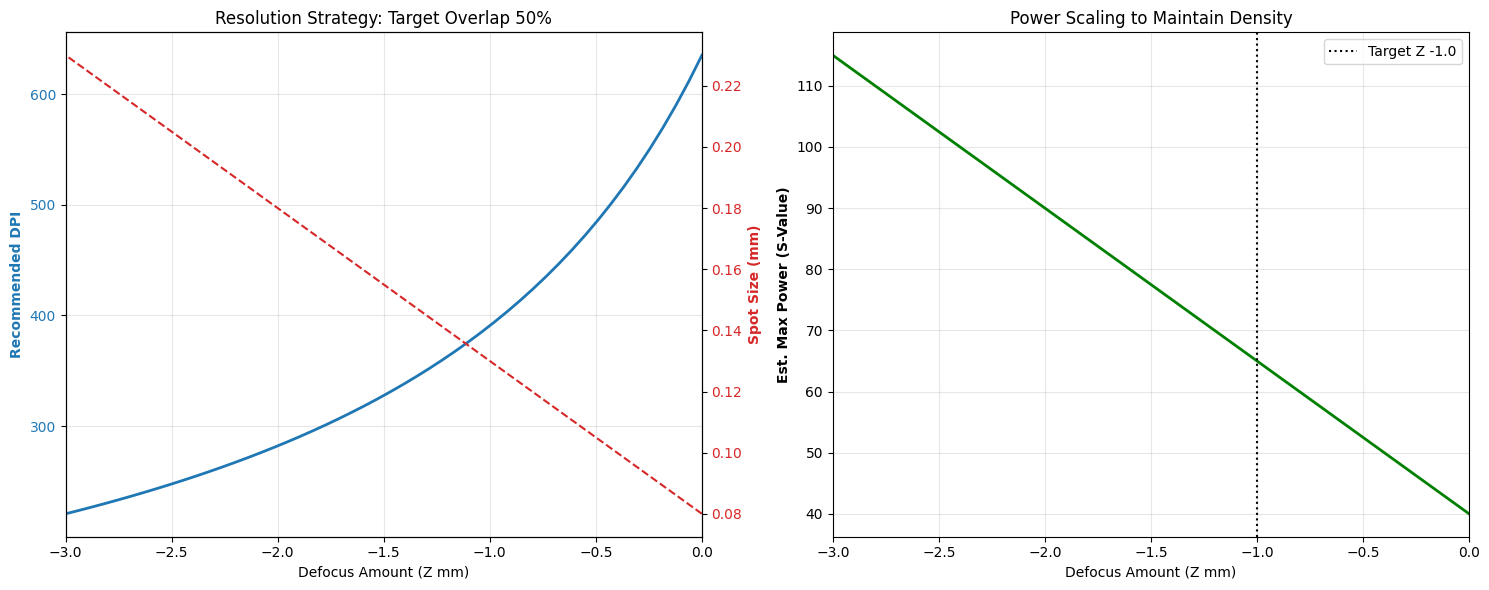

--- OPTIMIZED SETTINGS CALCULATOR ---
Target Z-Offset:     -1.0 mm
Target Feedrate:     3000 mm/min
Target PWM Freq:     4000 Hz
-----------------------------------
1. Calculated Spot:  0.130 mm
2. Line Interval:    0.065 mm
3. Recommended DPI:  390 DPI
-----------------------------------
4. Min Power (S):    14  (Start of burn)
5. Max Power (S):    65  (Solid Black)
-----------------------------------
6. PWM Stability:    10.4 pulses per dot
   Status:           PERFECT


In [54]:
import numpy as np
import matplotlib.pyplot as plt



# ==========================================
# 2. CALCULATION FUNCTIONS
# ==========================================

def get_spot_size(z_mm):
    """
    Linearly interpolates beam expansion based on TTS-55 optics.
    0mm = 0.08mm, 2mm = 0.18mm. Expansion rate ~0.05mm per mm depth.
    """
    slope = (base_spot_2mm - base_spot_0mm) / 2.0
    return base_spot_0mm + (slope * abs(z_mm))

def get_optimal_interval(spot_size, overlap):
    """Calculates line interval to maintain overlap."""
    return spot_size * (1 - overlap)

def get_dpi(interval_mm):
    return 25.4 / interval_mm

def get_power_scaling(current_z):
    """
    Scales power based on the change in line interval.
    If lines are tighter (higher DPI), we need LESS power per line to avoid charring.
    If lines are wider (lower DPI), we need MORE power to maintain darkness.
    """
    ref_spot = get_spot_size(ref_z)
    curr_spot = get_spot_size(current_z)
    
    # Calculate intervals
    ref_interval = get_optimal_interval(ref_spot, overlap_target)
    curr_interval = get_optimal_interval(curr_spot, overlap_target)
    
    # Power Scaling Factor: Ratio of intervals
    # Wider interval = Needs more power to cover the gap
    factor = curr_interval / ref_interval
    
    new_min = ref_power_min * factor
    new_max = ref_power_max * factor
    
    return min(new_min, max_scale), min(new_max, max_scale)

def check_pwm_overlap(speed_mm_min, freq_hz, spot_mm):
    speed_mm_sec = speed_mm_min / 60
    dist_per_pulse = speed_mm_sec / freq_hz
    overlaps = spot_mm / dist_per_pulse
    return overlaps

# ==========================================
# 3. GENERATE PLOTS
# ==========================================

# Create a range of Z-offsets from 0 to -4mm
z_values = np.linspace(0, -3, 50)
spots = [get_spot_size(z) for z in z_values]
dpis = [get_dpi(get_optimal_interval(s, overlap_target)) for s in spots]
intervals = [get_optimal_interval(s, overlap_target) for s in spots]
pwr_maxs = [get_power_scaling(z)[1] for z in z_values]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Focus vs. Resolution (DPI & Spot Size)
color = 'tab:blue'
ax1.set_xlabel('Defocus Amount (Z mm)')
ax1.set_ylabel('Recommended DPI', color=color, fontweight='bold')
ax1.plot(z_values, dpis, color=color, linewidth=2, label='DPI')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(0, -3)
ax1.invert_xaxis() # 0 on right, -3 on left
ax1.grid(True, alpha=0.3)

ax1_b = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax1_b.set_ylabel('Spot Size (mm)', color=color, fontweight='bold')
ax1_b.plot(z_values, spots, color=color, linestyle='--', label='Spot Size')
ax1_b.tick_params(axis='y', labelcolor=color)
ax1.set_title(f'Resolution Strategy: Target Overlap {int(overlap_target*100)}%')

# Plot 2: Power Requirements vs. Depth
ax2.plot(z_values, pwr_maxs, color='green', linewidth=2)
ax2.set_xlabel('Defocus Amount (Z mm)')
ax2.set_ylabel('Est. Max Power (S-Value)', fontweight='bold')
ax2.set_title('Power Scaling to Maintain Density')
ax2.set_xlim(0, -3)
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)

# Add reference lines for the user's current query
current_pwr_min, current_pwr_max = get_power_scaling(target_z)
current_spot = get_spot_size(target_z)
current_dpi = get_dpi(get_optimal_interval(current_spot, overlap_target))
ax2.axvline(target_z, color='black', linestyle=':', label=f'Target Z {target_z}')
ax2.legend()

plt.tight_layout()
plt.show()

# ==========================================
# 4. PRINT CALCULATOR RESULTS
# ==========================================
overlaps = check_pwm_overlap(feedrate, pwm_freq, current_spot)
quality_status = "PERFECT" if overlaps > 3 else "WARNING: DOTS VISIBLE"

print(f"--- OPTIMIZED SETTINGS CALCULATOR ---")
print(f"Target Z-Offset:     {target_z} mm")
print(f"Target Feedrate:     {feedrate} mm/min")
print(f"Target PWM Freq:     {pwm_freq} Hz")
print("-" * 35)
print(f"1. Calculated Spot:  {current_spot:.3f} mm")
print(f"2. Line Interval:    {get_optimal_interval(current_spot, overlap_target):.3f} mm")
print(f"3. Recommended DPI:  {int(current_dpi)} DPI")
print("-" * 35)
print(f"4. Min Power (S):    {int(current_pwr_min)}  (Start of burn)")
print(f"5. Max Power (S):    {int(current_pwr_max)}  (Solid Black)")
print("-" * 35)
print(f"6. PWM Stability:    {overlaps:.1f} pulses per dot")
print(f"   Status:           {quality_status}")
print("=====================================")

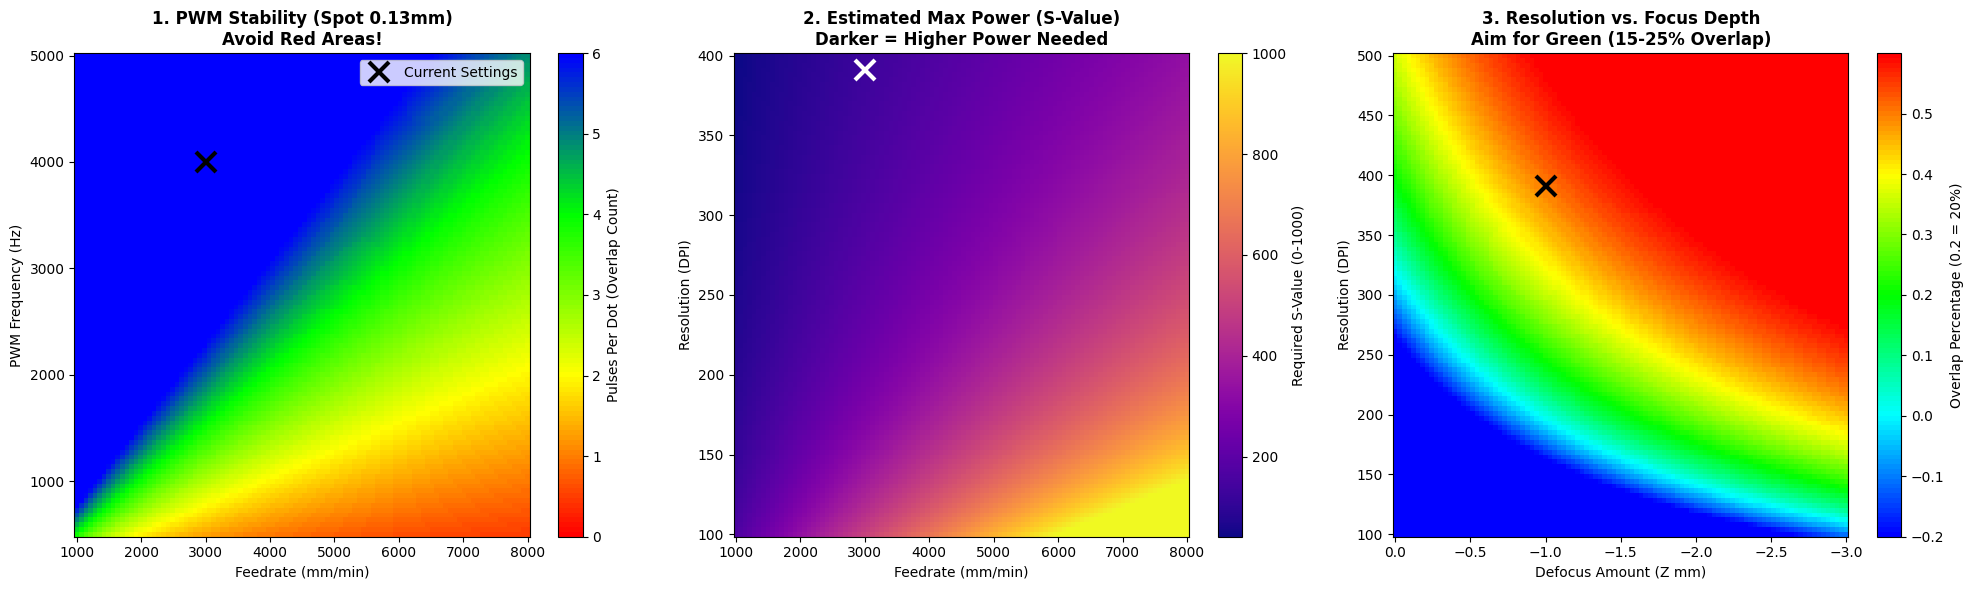

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ==========================================
# 1. SETUP PARAMETERS (Your Current Context)
# ==========================================
current_spot_size = current_spot

current_feedrate = feedrate
current_pwm = pwm_freq
current_dpi = current_dpi

# ==========================================
# 2. GENERATE DATA FOR MAPS
# ==========================================

# --- Map 1: PWM Stability (Speed vs Freq) ---
speed_range = np.linspace(1000, 8000, 100)
freq_range = np.linspace(500, 5000, 100)
X_pwm, Y_pwm = np.meshgrid(speed_range, freq_range)

# Calculate Pulses per Dot
# Formula: SpotSize / (Speed_mm_sec / Freq)
speed_mm_sec = X_pwm / 60
dist_per_pulse = speed_mm_sec / Y_pwm
Z_overlap_count = current_spot_size / dist_per_pulse

# --- Map 2: Power Requirements (Speed vs DPI) ---
# Assuming Z=-1mm (Spot 0.13) as baseline
dpi_range = np.linspace(100, 400, 100)
X_pwr, Y_pwr = np.meshgrid(speed_range, dpi_range)

# Base calibration: 4000mm/min @ 230 DPI = S-Value 290
base_speed = 4000
base_dpi = 230
base_power = 290

# Power Logic: 
# 1. Linear with speed (Faster = More Power)
# 2. Inverse with DPI (Lower DPI = Wider gaps = More Power needed per line to fill visual density)
Z_power = base_power * (X_pwr / base_speed) * (base_dpi / Y_pwr)
Z_power = np.clip(Z_power, 0, 1000) # Clamp to machine max

# --- Map 3: Focus Strategy (Z-Offset vs DPI) ---
z_range = np.linspace(0, -3.0, 100) # 0 to -3mm
dpi_range_z = np.linspace(100, 500, 100)
X_focus, Y_focus = np.meshgrid(z_range, dpi_range_z)

# Calculate Overlap %
# Spot size grows as we go deeper: 0.08 + (0.05 * abs(z))
spot_grid = 0.08 + (0.05 * np.abs(X_focus))
interval_grid = 25.4 / Y_focus
Z_overlap_pct = (spot_grid - interval_grid) / spot_grid
Z_overlap_pct = np.clip(Z_overlap_pct, -0.5, 1.0) # Clip for display

# ==========================================
# 3. PLOTTING
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- PLOT 1: PWM STABILITY ---
# Custom colormap: Red (Bad) -> Yellow (Ok) -> Green (Good) -> Blue (Excellent)
colors_pwm = [(1, 0, 0), (1, 1, 0), (0, 1, 0), (0, 0, 1)] 
cmap_pwm = mcolors.LinearSegmentedColormap.from_list("custom_pwm", colors_pwm, N=100)

c1 = axes[0].pcolormesh(X_pwm, Y_pwm, Z_overlap_count, cmap=cmap_pwm, vmin=0, vmax=6, shading='auto')
axes[0].set_title(f'1. PWM Stability (Spot {current_spot_size}mm)\nAvoid Red Areas!', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Feedrate (mm/min)')
axes[0].set_ylabel('PWM Frequency (Hz)')
# Add marker for current settings
axes[0].plot(current_feedrate, current_pwm, 'kx', markersize=15, markeredgewidth=3, label='Current Settings')
axes[0].legend(loc='upper right')
fig.colorbar(c1, ax=axes[0], label='Pulses Per Dot (Overlap Count)')

# --- PLOT 2: POWER REQUIREMENTS ---
c2 = axes[1].pcolormesh(X_pwr, Y_pwr, Z_power, cmap='plasma', shading='auto')
axes[1].set_title('2. Estimated Max Power (S-Value)\nDarker = Higher Power Needed', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Feedrate (mm/min)')
axes[1].set_ylabel('Resolution (DPI)')
# Add marker
axes[1].plot(current_feedrate, current_dpi, 'wx', markersize=15, markeredgewidth=3)
fig.colorbar(c2, ax=axes[1], label='Required S-Value (0-1000)')

# --- PLOT 3: FOCUS SWEET SPOT ---
# Custom Map: Blue(Gap) -> Green(Perfect) -> Red(Overlap/Trench)
colors_focus = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]
nodes = [0.0, 0.5, 1.0] # Scale mapping assumes normalized 0-1 later? No, let's map manual values.
# Let's map values: <0 (Gap, Blue), 0.15-0.30 (Sweet, Green), >0.5 (Trench, Red)
cmap_focus = mcolors.LinearSegmentedColormap.from_list("custom_focus", ["blue", "cyan", "lime", "yellow", "red"], N=100)
# Normalize center around 0.2 (20% overlap)
divnorm = mcolors.TwoSlopeNorm(vmin=-0.2, vcenter=0.2, vmax=0.6)

c3 = axes[2].pcolormesh(X_focus, Y_focus, Z_overlap_pct, cmap=cmap_focus, norm=divnorm, shading='auto')
axes[2].set_title('3. Resolution vs. Focus Depth\nAim for Green (15-25% Overlap)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Defocus Amount (Z mm)')
axes[2].set_ylabel('Resolution (DPI)')
axes[2].invert_xaxis() # 0 on right, deep on left
# Add marker
axes[2].plot(-1.0, current_dpi, 'kx', markersize=15, markeredgewidth=3)
fig.colorbar(c3, ax=axes[2], label='Overlap Percentage (0.2 = 20%)')

plt.tight_layout()
plt.show()